<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/Deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the dataset from the shared Google Drive

In [19]:
# ===== Imports =====
import os
import numpy as np
import pandas as pd


In [20]:
# ===== Detect if running in Google Colab and mount Drive =====
IN_COLAB = False
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    drive = None
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive/')

# ===== Define paths =====
if IN_COLAB:
    # Case 1: You manually placed the dataset in MyDrive
    DATA_PATH = "/content/drive/MyDrive/DeepLearningECG/data/"
    ARTIFACT_DIR = "/content/drive/MyDrive/DeepLearningECG/artifacts/"

else:
    # Case 3: Local fallback (if running outside Colab)
    DATA_PATH = "../data/"
    ARTIFACT_DIR = "../artifacts/"

print("DATA_PATH:", DATA_PATH)
print("ARTIFACT_DIR:", ARTIFACT_DIR)
print("Files in DATA_PATH:", os.listdir(DATA_PATH))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
DATA_PATH: /content/drive/MyDrive/DeepLearningECG/data/
ARTIFACT_DIR: /content/drive/MyDrive/DeepLearningECG/artifacts/
Files in DATA_PATH: ['ECGCode.csv', 'DiseaseCode.csv', 'ExampleReadingCode.ipynb', 'AttributesDictionary.csv', 'Child_ecg.zip', 'Child_ecg.z01', 'Child_ecg']


3. Load the CSV metadata

In [21]:
# ===== Load CSV metadata =====
ATTR_PATH = os.path.join(DATA_PATH, "AttributesDictionary.csv")
DISEASE_PATH = os.path.join(DATA_PATH, "DiseaseCode.csv")
ECGCODE_PATH = os.path.join(DATA_PATH, "ECGCode.csv")

df_attr = pd.read_csv(ATTR_PATH)
df_disease = pd.read_csv(DISEASE_PATH)
df_ecgcode = pd.read_csv(ECGCODE_PATH)

print("Attributes shape:", df_attr.shape)
display(df_attr.head())

print("DiseaseCode shape:", df_disease.shape)
display(df_disease.head())

print("ECGCode shape:", df_ecgcode.shape)
display(df_ecgcode.head())

Attributes shape: (14190, 14)


,Filename,ECG_ID,Patient_ID,Age,Gender,Acquisition_date,Sampling_point,Lead,AHA_code,CHN_code,ICD-10 code,pSQI,basSQI,bSQI
0,P00/P00001/P00001_E01,P00001_E01,P00001,572d,'Female',2017-11-22 10:46:08,9000,9,'Left ventricular high voltage';'L147','J106';'L123','I34.0';'Q21.0';'Q24.9','I':0.288;'II':0.323;'III':0.346;'aVR':0.312;'...,'I':0.994;'II':0.996;'III':0.991;'aVR':0.997;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...
1,P00/P00002/P00002_E01,P00002_E01,P00002,4327d,'Male',2017-11-28 21:59:47,15000,12,'C21','C13','I51.4';'J18.9','I':0.472;'II':0.446;'III':0.449;'aVR':0.484;'...,'I':0.995;'II':0.980;'III':0.992;'aVR':0.992;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...
2,P00/P00003/P00003_E01,P00003_E01,P00003,1087d,'Female',2017-11-29 16:04:57,10000,12,'C21','C13','Q21.0';'Q24.9','I':0.495;'II':0.347;'III':0.340;'aVR':0.382;'...,'I':0.915;'II':0.895;'III':0.882;'aVR':0.908;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...
3,P00/P00004/P00004_E01,P00004_E01,P00004,2465d,'Male',2017-11-30 15:21:27,13000,9,'C21','C13','Q21.1';'Q24.9','I':0.340;'II':0.405;'III':0.409;'aVR':0.350;'...,'I':0.981;'II':0.988;'III':0.974;'aVR':0.986;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...
4,P00/P00004/P00004_E02,P00004_E02,P00004,2461d,'Male',2017-11-26 19:19:48,15000,9,'A1','A1','Q21.1';'Q24.9','I':0.501;'II':0.494;'III':0.389;'aVR':0.525;'...,'I':0.993;'II':0.993;'III':0.989;'aVR':0.995;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...


DiseaseCode shape: (20, 4)


,Disease Type,Disease Category,ICD-10 Code,ICD-10 Description
0,Myocarditis,Fulminant myocarditis,(F) I40.0,Infective myocarditis;Septic myocarditis;Use a...
1,Myocarditis,Viral myocarditis,(V) I40.0,Infective myocarditis;Septic myocarditis;Use a...
2,Myocarditis,Acute myocarditis,I40.9,"Acute myocarditis, unspecified"
3,Myocarditis,Myocarditis,I51.4,"Myocarditis, unspecified;Myocardial fibrosis;M..."
4,Cardiomyopathy,Dilated cardiomyopathy,I42.0,Dilated cardiomyopathy;Congestive cardiomyopathy


ECGCode shape: (105, 3)


,Description,AHA(Category&Code),CHN(Category&Code)
0,Normal ECG,A1,A1
1,Otherwise normal ECG,A2,A2
2,Sinus tachycardia,C21,C13
3,Sinus bradycardia,C22,C14
4,Sinus arrhythmia,C23,C15


4. Simple data analysis (EDA)

In [22]:
# ===== Basic statistics and structure =====

print("Shape:", df_attr.shape)
print("\nColumn types:")
print(df_attr.dtypes)

print("\nMissing values per column:")
print(df_attr.isna().sum())

print("\n----- Numerical Summary -----")
display(df_attr.describe(include="all"))

Shape: (14190, 14)

Column types:
Filename            object
ECG_ID              object
Patient_ID          object
Age                 object
Gender              object
Acquisition_date    object
Sampling_point       int64
Lead                 int64
AHA_code            object
CHN_code            object
ICD-10 code         object
pSQI                object
basSQI              object
bSQI                object
dtype: object

Missing values per column:
Filename            0
ECG_ID              0
Patient_ID          0
Age                 0
Gender              0
Acquisition_date    0
Sampling_point      0
Lead                0
AHA_code            0
CHN_code            0
ICD-10 code         0
pSQI                0
basSQI              0
bSQI                0
dtype: int64

----- Numerical Summary -----


,Filename,ECG_ID,Patient_ID,Age,Gender,Acquisition_date,Sampling_point,Lead,AHA_code,CHN_code,ICD-10 code,pSQI,basSQI,bSQI
count,14190,14190,14190,14190,14190,14190,14190.000000,14190.000000,14190,14190,14190,14190,14190,14190
unique,14190,14190,11643,4909,2,14189,NaN,NaN,2314,2314,6653,14190,14190,10490
top,P11/P11643/P11643_E01,P11643_E01,P01702,2d,'Male',2019-04-19 16:16:18,NaN,NaN,'A1','A1','Q21.0','I':0.395;'II':0.500;'III':0.605;'aVR':0.442;'...,'I':0.995;'II':0.986;'III':0.977;'aVR':0.990;'...,'I':1.000;'II':1.000;'III':1.000;'aVR':1.000;'...
freq,1,1,19,44,8131,2,NaN,NaN,1882,1882,282,1,1,1523
mean,NaN,NaN,NaN,NaN,NaN,NaN,13504.157858,11.607611,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2778.427600,1.011568,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,10500.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,15000.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,15000.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN


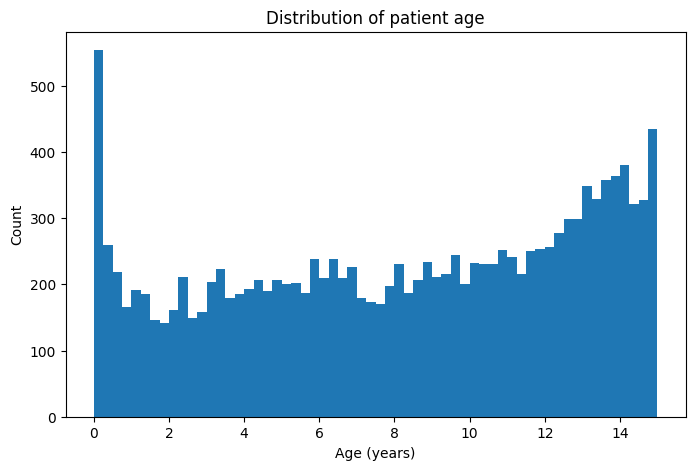

Min age (days): 1
Max age (days): 5474
Average age (days): 2983.5233967582803
Number of ECG records with age = 0 days: 0


In [23]:
# ===== Age distribution =====

# Age is stored as "###d" (days). Convert to integer days.
df_attr["Age_days"] = df_attr["Age"].str.replace("d", "").astype(int)
df_attr["Age_years"] = df_attr["Age_days"] / 365

plt.figure(figsize=(8,5))
plt.hist(df_attr["Age_years"], bins=60)
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.title("Distribution of patient age")
plt.show()

print("Min age (days):", df_attr["Age_days"].min())
print("Max age (days):", df_attr["Age_days"].max())
print("Average age (days):", df_attr["Age_days"].mean())

# How many have age = 0 days?
num_age_zero = (df_attr["Age_days"] == 0).sum()
print("Number of ECG records with age = 0 days:", num_age_zero)

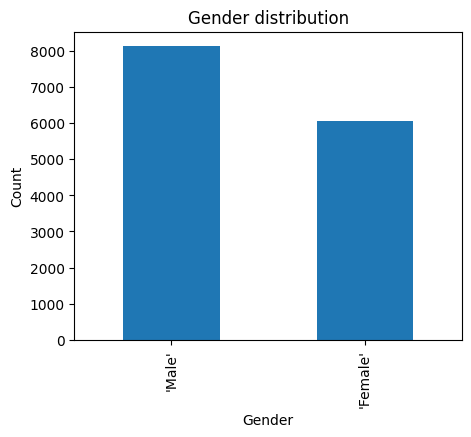

Gender
'Male'      8131
'Female'    6059
Name: count, dtype: int64


In [24]:
# ===== Gender distribution =====

plt.figure(figsize=(5,4))
df_attr["Gender"].value_counts().plot(kind="bar")
plt.title("Gender distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

print(df_attr["Gender"].value_counts())

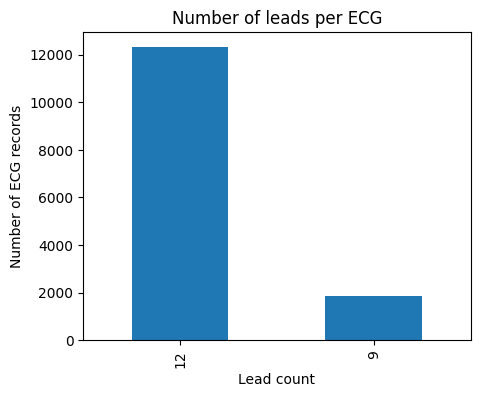

Lead
12    12334
9      1856
Name: count, dtype: int64


In [25]:
# ===== Number of electrodes per ECG (9 vs 12) =====

plt.figure(figsize=(5,4))
df_attr["Lead"].value_counts().plot(kind="bar")
plt.title("Number of leads per ECG")
plt.xlabel("Lead count")
plt.ylabel("Number of ECG records")
plt.show()

print(df_attr["Lead"].value_counts())

Average age (9-lead): 1.6965753424657537
Average age (12-lead): 9.148754417569432
Median age (9-lead): 1.0136986301369864
Median age (12-lead): 9.686301369863013
Min age 9-lead: 0.0027397260273972603
Min age 12-lead: 0.005479452054794521
Max age 9-lead: 6.983561643835617
Max age 12-lead: 14.997260273972604


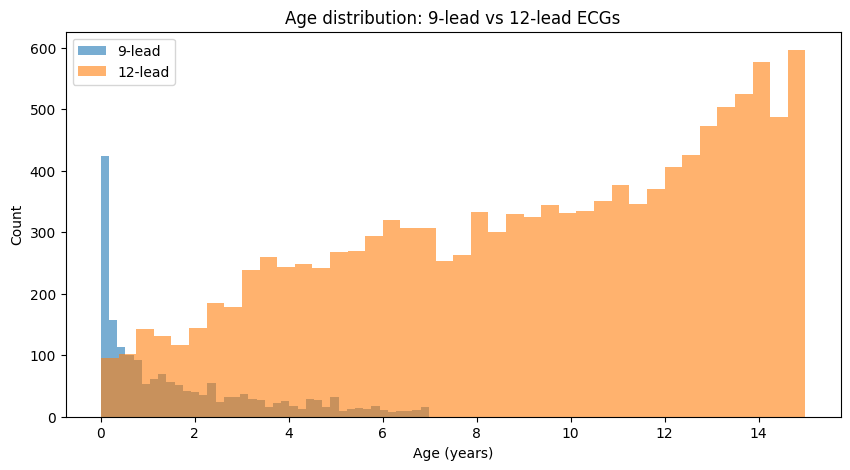

In [26]:
# Ensure Age_days exists
df_attr["Age_days"] = df_attr["Age"].str.replace("d", "").astype(int)
df_attr["Age_years"] = df_attr["Age_days"] / 365

# Split by lead type
df_9 = df_attr[df_attr["Lead"] == 9]
df_12 = df_attr[df_attr["Lead"] == 12]

print("Average age (9-lead):", df_9["Age_years"].mean())
print("Average age (12-lead):", df_12["Age_years"].mean())
print("Median age (9-lead):", df_9["Age_years"].median())
print("Median age (12-lead):", df_12["Age_years"].median())
print("Min age 9-lead:", df_9["Age_years"].min())
print("Min age 12-lead:", df_12["Age_years"].min())
print("Max age 9-lead:", df_9["Age_years"].max())
print("Max age 12-lead:", df_12["Age_years"].max())

# Plot both age distributions
plt.figure(figsize=(10,5))
plt.hist(df_9["Age_years"], bins=40, alpha=0.6, label="9-lead")
plt.hist(df_12["Age_years"], bins=40, alpha=0.6, label="12-lead")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.title("Age distribution: 9-lead vs 12-lead ECGs")
plt.legend()
plt.show()

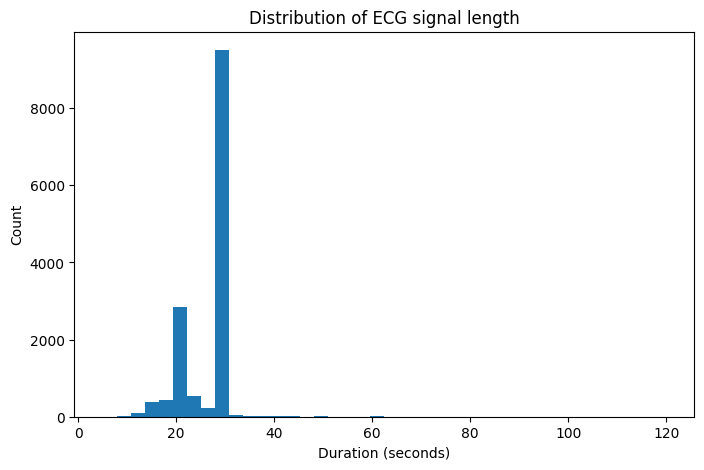

Min duration: 5.0 sec
Max duration: 120.0 sec
Average duration: 27.008315715292458 sec


,count
Duration_bin,
0-5s,0
5-10s,7
10-15s,147
15-20s,780
20-25s,3118
25-30s,618
30-35s,9422
35-40s,26
40-45s,10


In [27]:
# ===== ECG duration distribution =====
#Assuming sampling frequency = 500 Hz

df_attr["Duration_sec"] = df_attr["Sampling_point"] / 500

plt.figure(figsize=(8,5))
plt.hist(df_attr["Duration_sec"], bins=40)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of ECG signal length")
plt.show()

print("Min duration:", df_attr["Duration_sec"].min(), "sec")
print("Max duration:", df_attr["Duration_sec"].max(), "sec")
print("Average duration:", df_attr["Duration_sec"].mean(), "sec")

# Distribution in a table
# Create bins of 5 seconds
bins = list(range(0, int(df_attr["Duration_sec"].max()) + 5, 5))

df_attr["Duration_bin"] = pd.cut(
    df_attr["Duration_sec"],
    bins=bins,
    right=False,   # intervals like [0–5), [5–10), ...
    labels=[f"{b}-{b+5}s" for b in bins[:-1]]
)

duration_table = df_attr["Duration_bin"].value_counts().sort_index()
duration_table

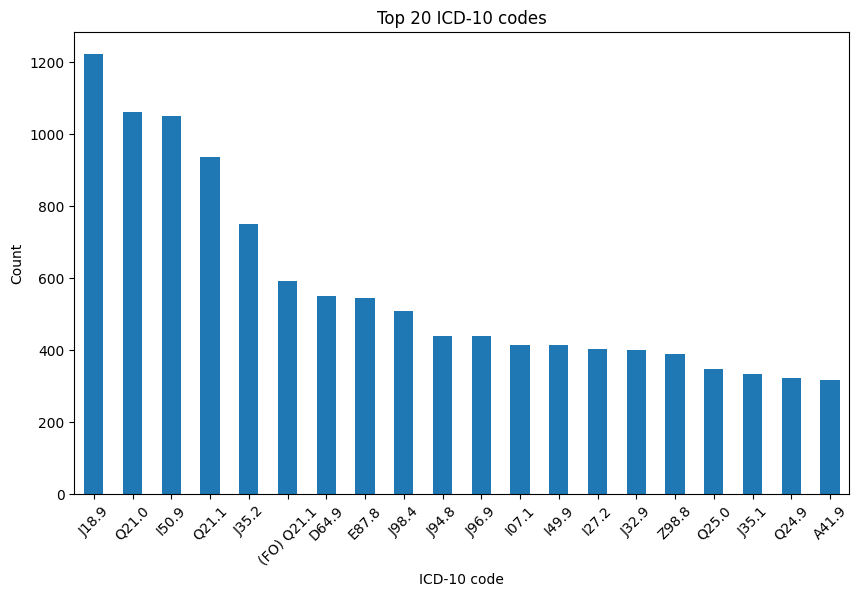

,count
J18.9,1223
Q21.0,1062
I50.9,1050
Q21.1,936
J35.2,751
(FO) Q21.1,593
D64.9,552
E87.8,546
J98.4,509
J94.8,440


In [28]:
# ===== ICD-10 disease label distribution =====
#The ICD-10 field has multiple codes separated by ;. We split and counted all codes.

# Split multi-code entries and flatten
codes = (
    df_attr["ICD-10 code"]
    .dropna()
    .str.replace("'", "")
    .str.split(";")
)

flattened = [code.strip() for list_ in codes for code in list_]

icd_counts = pd.Series(flattened).value_counts()

plt.figure(figsize=(10,6))
icd_counts.head(20).plot(kind="bar")
plt.title("Top 20 ICD-10 codes")
plt.xlabel("ICD-10 code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

icd_counts.head(20)

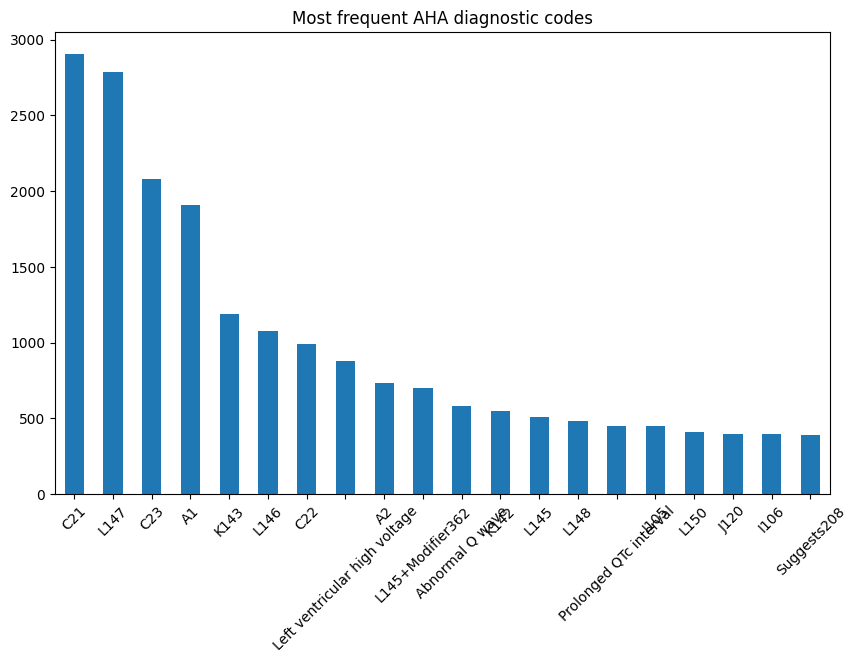

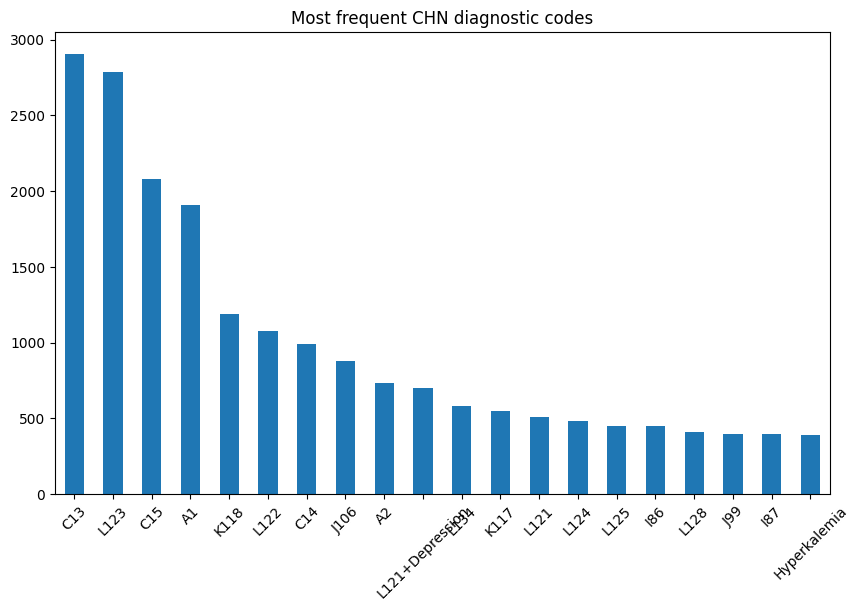

In [29]:
# ===== AHA and CHN code distributions =====

# Clean AHA code strings
df_attr["AHA_clean"] = df_attr["AHA_code"].str.replace("'", "")
aha_codes = df_attr["AHA_clean"].str.split(";")
aha_flat = [c.strip() for lst in aha_codes for c in lst]
aha_counts = pd.Series(aha_flat).value_counts()

plt.figure(figsize=(10,6))
aha_counts.head(20).plot(kind="bar")
plt.title("Most frequent AHA diagnostic codes")
plt.xticks(rotation=45)
plt.show()

# CHN codes
df_attr["CHN_clean"] = df_attr["CHN_code"].str.replace("'", "")
chn_codes = df_attr["CHN_clean"].str.split(";")
chn_flat = [c.strip() for lst in chn_codes for c in lst]
chn_counts = pd.Series(chn_flat).value_counts()

plt.figure(figsize=(10,6))
chn_counts.head(20).plot(kind="bar")
plt.title("Most frequent CHN diagnostic codes")
plt.xticks(rotation=45)
plt.show()

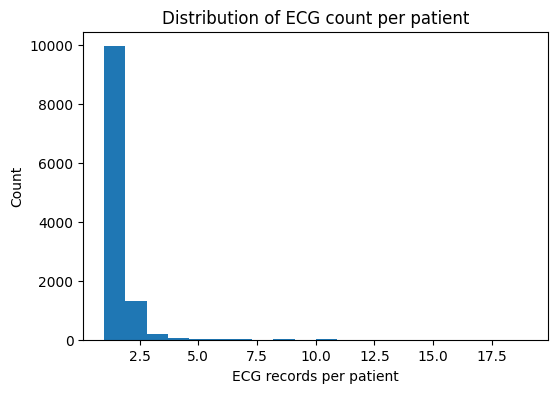

count    11643.000000
mean         1.218758
std          0.777619
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: count, dtype: float64


,ECG recordings per patient,Number of patients
0,1,9952
1,2,1327
2,3,202
3,4,66
4,5,33
5,6,18
6,7,9
7,8,7
8,9,11
9,10,9


In [30]:
# ===== Number of ECGs per patient =====

patient_counts = df_attr["Patient_ID"].value_counts()

plt.figure(figsize=(6,4))
plt.hist(patient_counts, bins=20)
plt.xlabel("ECG records per patient")
plt.ylabel("Count")
plt.title("Distribution of ECG count per patient")
plt.show()

print(patient_counts.describe())

# Table: ECG count → number of patients
ecg_count_table = patient_counts.value_counts().sort_index()

# Convert to DataFrame
ecg_count_df = pd.DataFrame({
    "ECG recordings per patient": ecg_count_table.index,
    "Number of patients": ecg_count_table.values
})

display(ecg_count_df)